# Combined Cycle Power Plant Data Set


**Data Set Information:**

The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the
power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (T),
Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output
(EP) of the plant.
A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam
generators. In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is
transferred from one turbine to another. While the Vacuum is colected from and has effect on the Steam Turbine, he other
three of the ambient variables effect the GT performance.
For comparability with our baseline studies, and to allow 5x2 fold statistical tests be carried out, we provide the data
shuffled five times. For each shuffling 2-fold CV is carried out and the resulting 10 measurements are used for statistical
testing.
We provide the data both in .ods and in .xlsx formats.

**Attribute Information:**

Features consist of hourly average ambient variables
- Temperature (T) in the range 1.81°C and 37.11°C,
- Ambient Pressure (AP) in the range 992.89-1033.30 milibar,
- Relative Humidity (RH) in the range 25.56% to 100.16%
- Exhaust Vacuum (V) in teh range 25.36-81.56 cm Hg
- Net hourly electrical energy output (EP) 420.26-495.76 MW1/29/2020 UCI Machine Learning Repository: Combined Cycle Power Plant Data Set

The averages are taken from various sensors located around the plant that record the ambient variables every second.
The variables are given without normalization.

Generic imports

In [27]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np

IMPORT DATAS

In [28]:
# datas splited on 5 sheets
# dfall = pd.read_excel('./Folds5x2_pp.xlsx',sheet_name=None)
# df = pd.concat(dfall,axis=0)

df = pd.read_excel('./Folds5x2_pp.xlsx')

FIRST LOOK AT DATAS

In [29]:
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
AT    9568 non-null float64
V     9568 non-null float64
AP    9568 non-null float64
RH    9568 non-null float64
PE    9568 non-null float64
dtypes: float64(5)
memory usage: 373.9 KB


In [31]:
df.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


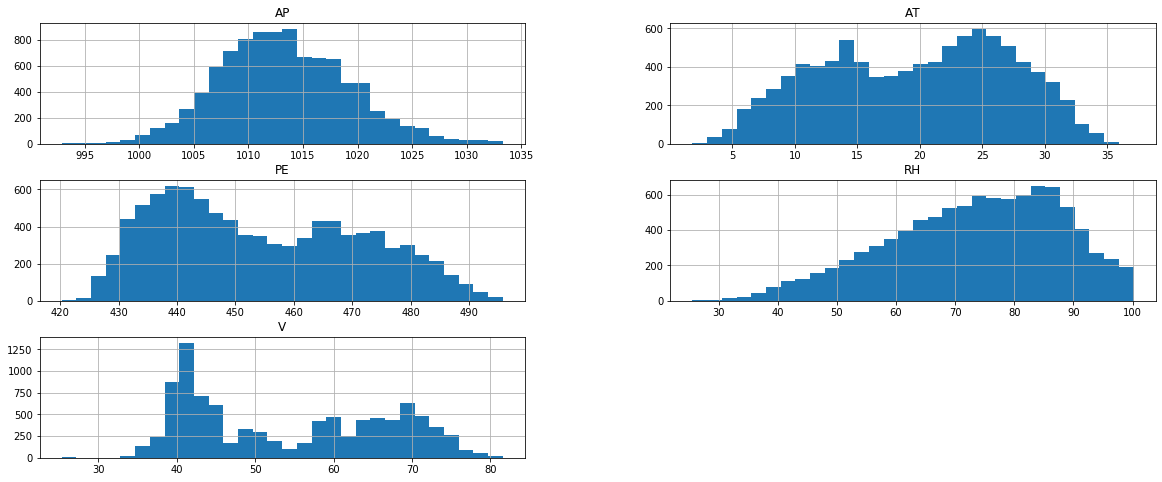

In [32]:
df.hist(bins=30,figsize=(20,8));

In [33]:
corr_matrix = df.corr()

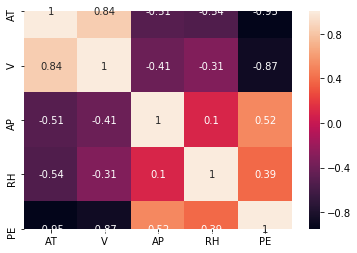

In [34]:
sns.heatmap(corr_matrix,annot=True);

In [35]:
corr_matrix["PE"].sort_values(ascending=False)

PE    1.000000
AP    0.518429
RH    0.389794
V    -0.869780
AT   -0.948128
Name: PE, dtype: float64

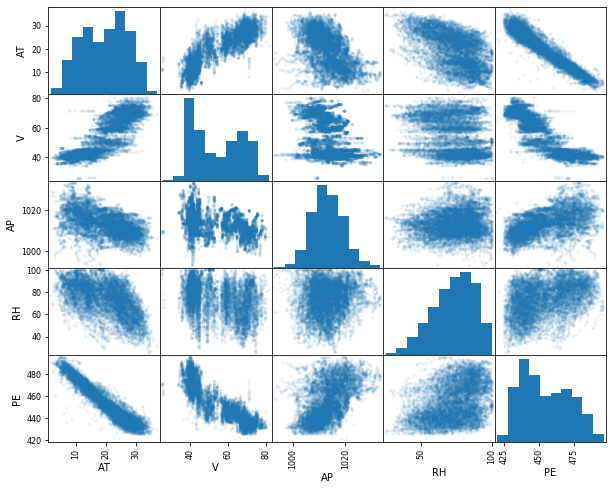

In [36]:
from pandas.plotting import scatter_matrix

scatter_matrix(df,figsize=(10,8),alpha=0.1);

CREATE TRAIN/TEST SETS

In [37]:
from sklearn.model_selection import train_test_split

X=df.drop(labels='PE', axis=1)
Y=df['PE']

# Create train and test sets
xtrain,xtest,ytrain,ytest= train_test_split(X,Y,test_size=0.2,random_state=37)

SCALE EXPLANATORY VARIABLES

In [38]:
from sklearn.preprocessing import StandardScaler

# Scale x data
scaler = StandardScaler()
scaler.fit(xtrain)

xtrain_s = scaler.transform(xtrain)
xtest_s = scaler.transform(xtest)

TRY DIFFERENT REGRESSOR FOR FIRST EVALUATION

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

regressor = [
            LinearRegression(),
            KNeighborsRegressor(),
            SVR(),
            DecisionTreeRegressor(random_state=37),
            RandomForestRegressor(random_state=37),
            AdaBoostRegressor(random_state=37),
           ]

reg_names=[
            'Linear', 
            'KNN',
            'SVR',
            'Decision Tree',
            'RandomForest',
            'AdaBoost',
            ]

# Apply different classifiers
bestscore=0
bestclf =''
for name, clf in zip(reg_names, regressor):
    reg = clf.fit(xtrain_s, ytrain)
    
    score1 = reg.score(xtest_s, ytest)*100
    print("%s Score : %.2f %%" % (name, score1))
    if score1 > bestscore:
        bestscore = score1
        ypred = reg.predict(xtest_s)
        bestclf = name

Linear Score : 92.88 %
KNN Score : 94.56 %
SVR Score : 94.07 %
Decision Tree Score : 92.65 %
RandomForest Score : 95.87 %
AdaBoost Score : 88.22 %


In [40]:
print('Best score using: %s' % bestclf)

Best score using: RandomForest


CHECK ERROR OF BEST REGRESSOR

In [41]:
from sklearn.metrics import mean_squared_error

best_reg_mse = mean_squared_error(ytest,ypred)
best_reg_rmse = np.sqrt(best_reg_mse)

best_reg_rmse

3.4605982407877347

CROSS VALIDATION EVALUATION

In [42]:
from sklearn.model_selection import cross_val_score

reg = RandomForestRegressor(random_state=37)
model = reg.fit(xtrain_s, ytrain)

cross_mse = cross_val_score(model,xtrain_s, ytrain,scoring='neg_mean_squared_error',cv=10)
cross_rmse = np.sqrt(-cross_mse)                            

print("MSE scores:",cross_rmse)
print("avg:",cross_rmse.mean())
print("std dev:",cross_rmse.std())

MSE scores: [3.41912847 3.22849754 3.31732883 3.29962358 3.42079846 3.10257466
 3.9269291  3.11476097 3.22401446 3.32236302]
avg: 3.3376019084617297
std dev: 0.22195993503827952


TRY MODEL IMPROVEMENT BY TUNING PARAMETERS USING GRID SEARCH

In [44]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'bootstrap':[True,False],
        'n_estimators':[5,10,100,],
        'max_features':[2,3,4,'auto'],
        'max_depth':[5,10,None],
    }
]

reg = RandomForestRegressor(random_state=37)
grid_search = GridSearchCV(reg,param_grid,cv=10,scoring='neg_mean_squared_error',return_train_score=True)
grid_search.fit(xtrain_s,ytrain);


In [45]:
grid_search.best_params_

{'bootstrap': False, 'max_depth': None, 'max_features': 2, 'n_estimators': 100}

In [46]:
best_grid_mse = grid_search.best_score_
best_grid_rmse = np.sqrt(-grid_search.best_score_)
best_grid_rmse

3.1899875168766423

EVALUATE MODEL ON TEST DATASET

In [47]:
ypred = grid_search.best_estimator_.predict(xtest_s)

score = grid_search.best_estimator_.score(xtest_s, ytest)*100

mse = mean_squared_error(ytest,ypred)
rmse = np.sqrt(mse)

print("Model score: %.2f%% giving an error of %.2f MW on test dataset (%d obs)" % (score,rmse,len(ytest)))


Model score: 96.21% giving an error of 3.32 dB on test dataset (1914 obs)
